In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, BigBirdTokenizer
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
import textstat
import torch
import numpy as np
import xgboost

In [74]:
prompts_train = pd.read_csv('./data/prompts_train.csv')
summaries_train = pd.read_csv('./data/summaries_train.csv')
prompts_test = pd.read_csv('./data/prompts_test.csv')
summaries_test = pd.read_csv('./data/summaries_test.csv')

In [75]:
summaries_train['word_counts'] = summaries_train['text'].apply(lambda x : len(set(x.lower().split(' '))))
summaries_train['smog_index'] = summaries_train['text'].apply(lambda x : textstat.smog_index(x))
prompts_train['prompt_text'] = prompts_train['prompt_text'].str.replace('\r','')
prompts_train['prompt_text'] = prompts_train['prompt_text'].str.replace('\n','')

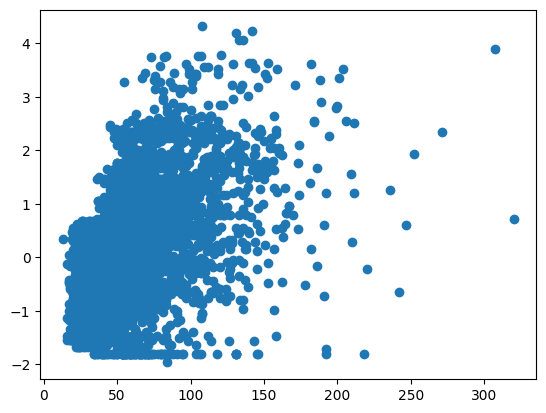

In [76]:
plt.scatter(summaries_train['word_counts'], summaries_train['wording'])
plt.show()

In [77]:
stats.pearsonr(summaries_train['smog_index'], summaries_train['wording'])

PearsonRResult(statistic=0.542889063458692, pvalue=0.0)

In [78]:
encoded_prompts = []
for prompt_text in prompts_train['prompt_text']:
    encoded_prompts.append(tokenizer.encode(prompt_text))
prompts_train['encoded_prompt'] = encoded_prompts

In [80]:
def filter_(x, y):
    count = 0
    for num in y:
        if num in x:
            count += 1
    return count

In [99]:
counts_duplicate = []
for i in range(len(summaries_train)):
    student_text = summaries_train.iloc[i]['text']
    prompt_id = summaries_train.iloc[i]['prompt_id']
    encoded_prompt = prompts_train[prompts_train['prompt_id'] == prompt_id]['encoded_prompt'].tolist()[0]
    encoded_text = tokenizer.encode(student_text)
    count_duplicate = len(set(encoded_text) & set(encoded_prompt))
    counts_duplicate.append(count_duplicate)
summaries_train['counts_duplicate'] = counts_duplicate

In [100]:
summaries_train

,student_id,prompt_id,text,content,wording,word_counts,smog_index,counts_duplicate
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,49,10.7,30
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,37,0.0,37
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,142,9.3,94
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,18,9.7,19
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,135,10.1,60
...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,48,0.0,39
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,29,3.1,27
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,43,7.8,25
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,41,6.4,26


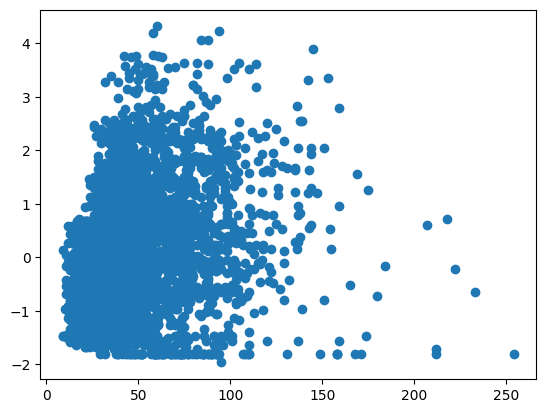

In [101]:
plt.scatter(summaries_train['counts_duplicate'], summaries_train['wording'])
plt.show()

In [97]:
stats.pearsonr(summaries_train['counts_duplicate'], summaries_train['wording'])


PearsonRResult(statistic=0.4171234386079206, pvalue=1.078944784473596e-299)

In [8]:
train = summaries_train.merge(prompts_train, on='prompt_id', how = 'left')

In [10]:
model = AutoModel.from_pretrained('allenai/longformer-base-4096')

In [10]:
cos_sim = []
model.cuda()
for i in tqdm(range(len(train))):
    text_1 = train['text'][i]
    prompt_1 = train['prompt_text'][i]
    input_text = tokenizer(text_1,max_length=1024,return_tensors='pt')
    input_text = {i: v.to("cuda") for i, v in input_text.items()}
    input_prompt = tokenizer(prompt_1,max_length=2048,return_tensors='pt')
    input_prompt = {i: v.to("cuda") for i, v in input_prompt.items()}
    with torch.no_grad():
        text_output = model(**input_text)
        prompt_output = model(**input_prompt)
    text_output = text_output.pooler_output
    prompt_output = prompt_output.pooler_output
    cos_sim.append(cosine_similarity(text_output.detach().cpu(), prompt_output.detach().cpu()))

100%|██████████| 7165/7165 [11:45<00:00, 10.16it/s]


In [46]:
scaler = MinMaxScaler()
train['cos_sim'] = np.array(cos_sim).flatten()
train['cos_sim'] = scaler.fit_transform(train[['cos_sim']]).flatten()

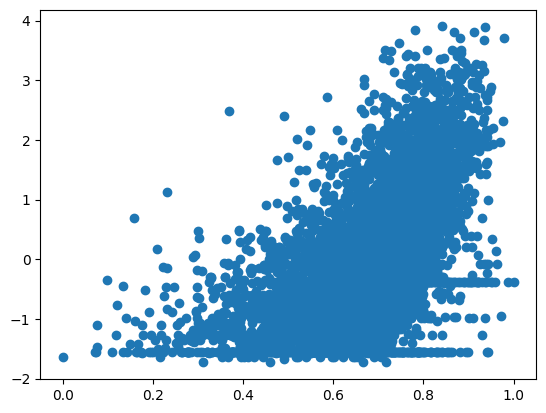

In [52]:
plt.scatter(train['cos_sim'], train['content'])
plt.show()